In [1]:
# import os, sys
# sep = os.sep
# # Добавить в путь до родительской папки\n",
# sys.path.append(os.path.join(sys.path[0], f'..{sep}'))
# #sys.path.append(os.path.join(os.getcwd(), f'..{sep}'))

In [2]:
import os
#
import numpy as np
import matplotlib.pyplot as plt
#
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision
import torchvision.transforms as T

%matplotlib inline

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# 1. Steps Involved in Training GANs 

In [4]:
pass

# 2. Preparing Training Data

In [6]:
# Поскольку обычно модели обучаются на пакетах данных, количество наблюдений
# в обучающем наборе данных стараются установить кратным размеру пакета 'batch_size'
2048 / 128

16.0

In [7]:
train_data[:, 0].min(), train_data[:, 0].max()

(tensor(0.0040), tensor(49.9919))

In [8]:
train_data[:, 1].min(), train_data[:, 1].max()

(tensor(1.0003), tensor(46.8725))

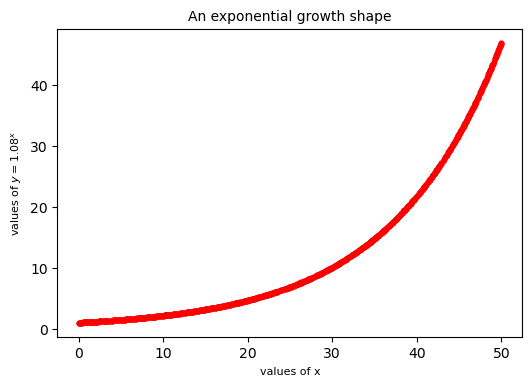

In [9]:
fig = plt.figure(figsize=(6, 4), dpi=100)

plt.plot(train_data[:, 0], train_data[:,1], '.', c='r')
plt.xlabel('values of x', fontsize=8)
plt.ylabel('values of $y=1.08^x$', fontsize=8)
plt.title('An exponential growth shape', fontsize=10)
plt.show();

In [10]:
batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [11]:
batch0 = next(iter(train_loader))
#print(batch0)
print(batch0.shape)

torch.Size([128, 2])


# 3. Creating GANs for Shape Generation

In [12]:
# Discriminator D is binary classifier
D = nn.Sequential(
    nn.Linear(2, 256), nn.ReLU(), nn.Dropout(0.3),
    nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.3),
    nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.3),
    nn.Linear(64, 1),
    # Сжать число на выходе до диапазона [0.0, 1.0]
    # 1 - образец реальный; 0 - образец поддельный
    nn.Sigmoid()
).to(device)

In [5]:
torch.manual_seed(0)

# Количество строк
observations = 2048
train_data = torch.zeros((observations, 2))

'''
# Значения в диапазоне [-5.0, 5.0)
train_data[:, 0] = 10 * (torch.rand(observations) - 0.5)
# Значения => y=sin(x)
train_data[:, 1 ]= torch.sin(train_data[:, 0])
'''

# Первая колонка
# Значения в диапазоне [0.0, 50.0)
train_data[:, 0] = 50 * torch.rand(observations)
# Вторая колонка
# Значения => y=1.08^x
train_data[:, 1 ]= 1.08 ** train_data[:, 0]

In [13]:
# Генератор пытается минимизировать вероятность того, что
# поддельный образец будет идентифицирован как поддельный
G = nn.Sequential(
    # На входе будет вектор (случайного шума) длиной 2,
    # но изменение размерности на другие числа, например,
    # 5 или 10, недолжно повлият на результаты
    nn.Linear(2, 16), nn.ReLU(),
    nn.Linear(16, 32), nn.ReLU(),
    # На выходе 2 числа
    # В идеале генератор должен натренироваться так чтобы
    # на выходе, второе число было равно 1.08^первое число
    nn.Linear(32, 2)
).to(device)

In [14]:
lr = 0.0005
optimD = torch.optim.Adam(D.parameters(), lr=lr)
optimG = torch.optim.Adam(G.parameters(), lr=lr)

# Loss Function for Discriminator and Generator (для Backpropagation)
# Binary cross-entropy loss function (Кросс-энтропия для бинарной классификации)
loss_fn = nn.BCELoss()

In [15]:
# Loss Function => Среднеквадратичная ошибка (MSE)
mse = nn.MSELoss()

# Мера для измерения качества работы генератора
# По сути, возвращает loss между поддельными и раельными данными
def performance(fake_samples):
    real = 1.08 ** fake_samples[:, 0]
    # Среднеквадратичная ошибка (MSE)
    # между сгенерированными данными - fake_samples[:, 1]
    # и реальными данными - real
    mse_loss = mse(fake_samples[:, 1], real)
    return mse_loss

In [16]:
# Класс для ранней остановки обучения, если
# перестало улучшаться качества работы генератора
class EarlyStop:
    def __init__(self, patience=1000):
        self.patience = patience
        self.steps = 0
        # Максимально возможное большое число для float
        self.min_gdif = float('inf')
    
    def stop(self, gdif):
        # Если достигается новая минимальная разница между
        # сгенерированными данными и истинными данными
        if gdif < self.min_gdif:
            self.min_gdif = gdif
            self.steps = 0
        elif gdif >= self.min_gdif:
            self.steps += 1
        # Если за self.patience эпох, значение функции потерь НЕ уменшилось
        # (сгенерированные образцы перестают улучшать свое качество)
        if self.steps >= self.patience:
            return True
        else:
            return False

#stopper = EarlyStop()

# 4. Train and Use GANs for Shape Generation

In [17]:
# Метки для истинных образцов
real_labels = torch.ones((batch_size, 1))
real_labels = real_labels.to(device)

# Метки для сгенерированных образцов
fake_labels = torch.zeros((batch_size, 1))
fake_labels = fake_labels.to(device)

In [18]:
# Один шаг тренировки Discriminator на истинных данных
def train_D_on_real(real_samples):
    real_samples = real_samples.to(device)
    # Работа дискриминатора (здесь он должен выдать вероятности близкие к 1)
    out_D = D(real_samples)

    labels1 = torch.ones((real_samples.shape[0], 1)).to(device)

    # Backpropagation
    optimD.zero_grad()
    # labels1: Все 1
    loss_D = loss_fn(out_D, labels1)
    loss_D.backward()
    optimD.step()  # Изменяем веса дискриминатора
    
    return loss_D

In [19]:
# Один шаг тренировки Discriminator на сгенерированных данных
def train_D_on_fake():
    # Нормальное распределение с mean=1, std=1
    noise = torch.randn((batch_size, 2))
    noise = noise.to(device)

    # Generator генерирует данные
    fake_samples = G(noise)
    # Работа дискриминатора (здесь он должен выдать вероятности близкие к 0)
    out_D = D(fake_samples)

    # Backpropagation
    optimD.zero_grad()
    # fake_labels: Все 0
    loss_D = loss_fn(out_D, fake_labels)
    loss_D.backward()
    optimD.step()  # Изменяем веса дискриминатора
    
    return loss_D

In [20]:
# Один шаг тренировки Generator на сгенерированных данных
def train_G():
    # Нормальное распределение с mean=1, std=1
    noise = torch.randn((batch_size, 2))
    noise = noise.to(device)

    # Generator генерирует данные
    # Задача генератора обмануть дискриминатор
    # (чтобы он поддельные данные принял за истинные)
    fake_samples = G(noise)
    # Работа дискриминатора
    # Возвращает вероятности того, что сгенерированные
    # данные являются истинными
    out_G = D(fake_samples)

    # Backpropagation
    optimG.zero_grad()
    # real_labels: Все 1
    loss_G = loss_fn(out_G, real_labels)
    loss_G.backward()
    optimG.step()  # Изменяем веса генератора
    
    return loss_G, fake_samples

In [21]:
dir_name = 'files'
os.makedirs(dir_name, exist_ok=True)

In [22]:
# Функция выводит информацию в процессе тренировки
def test_epoch(epoch, g_loss, d_loss, n, fake_samples):
    if epoch==0 or (epoch+1)%250==0:
        g = g_loss.item()/n
        d = d_loss.item()/n
        print(f'At epoch {epoch+1} => G loss: {g:.6f}, D loss: {d:.6f}')
        
        fake = fake_samples.detach().cpu().numpy()
        
        plt.figure(figsize=(6, 4), dpi=100)
        plt.plot(fake[:, 0], fake[:, 1], '*', c='g', label='generated samples')
        plt.plot(train_data[:, 0], train_data[:,1], '.', c='r', label='real samples', alpha=0.1)
        plt.title(f'Eepoch {epoch+1}', fontsize=10)
        plt.xlim(0, 50)
        plt.ylim(0, 50)
        plt.legend()
        plt.savefig(f'{dir_name}{os.sep}p{epoch+1}.png')
        plt.show();

At epoch 1 => G loss: 0.783738, D loss: 0.846893


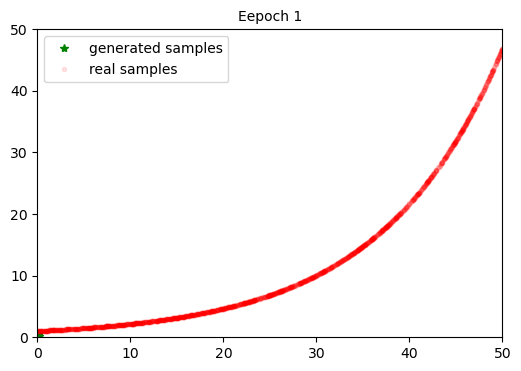

At epoch 250 => G loss: 0.790921, D loss: 1.478352


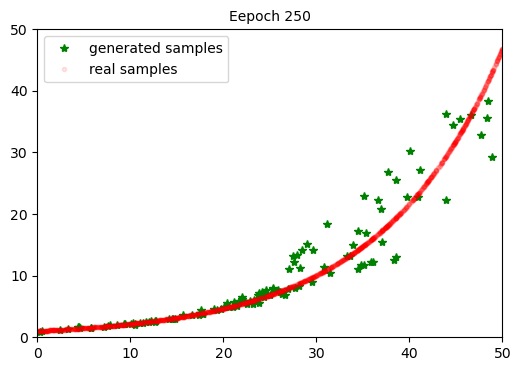

At epoch 500 => G loss: 0.756582, D loss: 1.478827


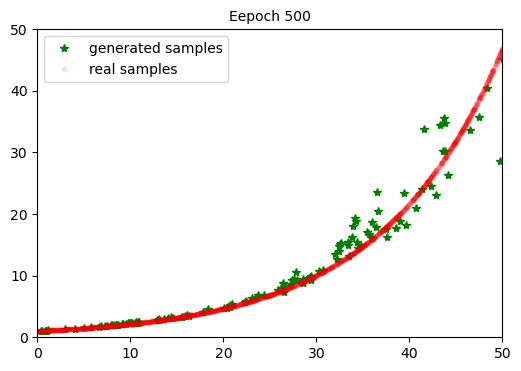

At epoch 750 => G loss: 0.757572, D loss: 1.473720


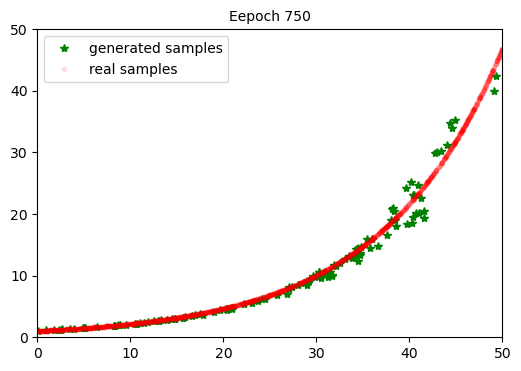

At epoch 1000 => G loss: 0.767332, D loss: 1.466115


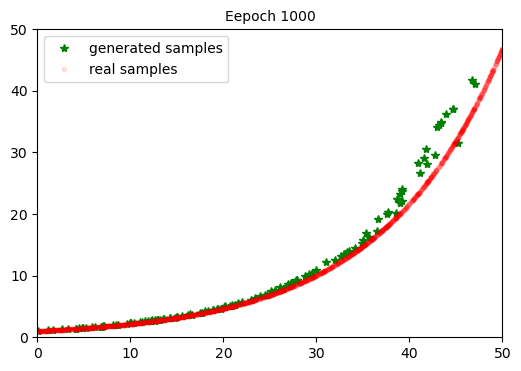

In [23]:
stopper = EarlyStop()
n_epoch = 10000

for epoch in range(n_epoch):
    g_loss = 0
    d_loss = 0
    for n, real_samples in enumerate(train_loader):
        # Обучение Discriminator
        loss_D = train_D_on_real(real_samples)
        d_loss += loss_D.detach()
        loss_D = train_D_on_fake()
        d_loss += loss_D.detach()
        
        # Обучение Generator
        loss_G, fake_samples = train_G()
        g_loss += loss_G.detach()
        
    test_epoch(epoch, g_loss, d_loss, n, fake_samples)

    # Вычислить количественное измерение качества работы генератора
    gdif = performance(fake_samples).item()
    # Ранняя остановка обучения
    if stopper.stop(gdif) == True:
        break

In [24]:
# Save Trained Model
dir_name = 'files'
file_name = 'exponential.pth'
os.makedirs(dir_name, exist_ok=True)

# Метод torch.jit.script() создает скрипт функции
# или класса nn.Module как код TorchScript
# с использованием компилятора TorchScript.
scripted = torch.jit.script(G) 
scripted.save(f'{dir_name}{os.sep}{file_name}')

In [25]:
# Load Trained Model
# Чтобы загрузить модель, даже не нужно ее определять. Просто загружаем сохраненный файл
new_G = torch.jit.load(f'{dir_name}{os.sep}{file_name}', map_location=device)
new_G.eval()

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Linear)
  (1): RecursiveScriptModule(original_name=ReLU)
  (2): RecursiveScriptModule(original_name=Linear)
  (3): RecursiveScriptModule(original_name=ReLU)
  (4): RecursiveScriptModule(original_name=Linear)
)

In [26]:
new_G.eval()

# Нормальное распределение с mean=1, std=1
noise = torch.randn((batch_size, 2)).to(device)
new_data = new_G(noise)

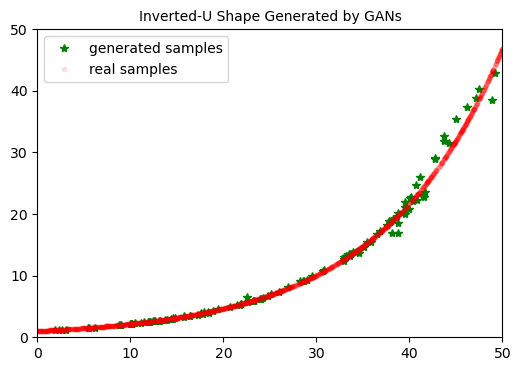

In [27]:
plt.figure(figsize=(6, 4), dpi=100)

x_fake = new_data.detach().cpu().numpy()[:, 0]
y_fake = new_data.detach().cpu().numpy()[:, 1]

plt.plot(x_fake, y_fake, '*', c='g', label='generated samples')
plt.plot(train_data[:, 0],train_data[:, 1], '.', c='r', label='real samples', alpha=0.1)
plt.title('Inverted-U Shape Generated by GANs', fontsize=10)
plt.xlim(0, 50)
plt.ylim(0, 50)
plt.legend()
plt.show();

# 5	Generating Numbers with Patterns

## 5.1 What Are One-Hot Variables?

In [28]:
def onehot_encoder(position, depth):
    onehot = torch.zeros((depth,))
    onehot[position] = 1
    # onehot: Вектор-строка (длиной depth),
    # одно из значений (с индексом position) = 1.0, остальные = 0.0
    return onehot

print(onehot_encoder(1, 5))

tensor([0., 1., 0., 0., 0.])


In [29]:
def int_to_onehot(number):
    # onehot: Вектор-строка (длиной 100),
    # одно из значений (с индексом number) = 1.0, остальные = 0.0
    onehot = onehot_encoder(number, 100)
    return onehot

onehot75 = int_to_onehot(75)
print(onehot75)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [30]:
def onehot_to_int(onehot):
    # Из вектор-строки поличить индекс элемента массива, в котором значение = 1
    # num может принимать значения в диапазоне от 0 до 99
    num = torch.argmax(onehot)
    return num.item()

print(onehot_to_int(onehot75))

75


## 5.2 GANs to Generate Numbers with Patterns 

In [31]:
# Функция генерирует последовательность из 10 целых чисел, все кратные 5:
def gen_sequence():
    # Вектор-строка (длиной 10), с равномерным
    # распределением в диапазоне [0, 20)
    indices = torch.randint(0, 20, (10,))
    values = indices * 5
    # values: Вектор-строка (длиной 10) все значения, которого кратны 5
    # и лежат в диапазоне [0, 95]
    return values

sequence = gen_sequence()
print(sequence)

tensor([30, 60, 10, 40, 35,  0, 50, 70, 15, 70])


In [32]:
def gen_batch():
    # sequence: Вектор-строка (длиной 10) все значения, которого кратны 5
    sequence = gen_sequence()
    # Преобразуем каждое целое число в переменную one-hot размером 100
    batch = [int_to_onehot(i).numpy() for i in sequence]
    batch = np.array(batch)

    # batch: Двумерная матрица 10х100. Одно из значений в каждой строке = 1.0, остальные = 0.0
    # Индекс элемента со значением = 1, всегда кратен 5
    return torch.tensor(batch)

batch = gen_batch()
batch.shape

torch.Size([10, 100])

In [33]:
# data: Двумерная матрица 10х100. Одно из значений в каждой строке = 1.0, остальные = 0.0
# Индекс элемента со значением = 1, всегда кратен 5
def data_to_nums(data):
    # dim=-1: Найти индекс наибольшего значения в последнем измерении.
    # Т.е. в данном случае, поиск идет в каждой строке (свертка колонок)
    nums = torch.argmax(data, dim=-1)
    # nums: Вектор-строка (длиной 10) все значения, которого кратны 5
    return nums
    
numbers = data_to_nums(batch)
numbers

tensor([95, 80, 50, 75, 65, 90, 75, 60, 15,  5])

In [34]:
D = nn.Sequential(
    # На вход 100 чисел: переменная one-hot размером 100,
    # на выходе одно число
    nn.Linear(100, 1),
    # Сжать число на выходе до диапазона [0.0, 1.0]
    # 1 - образец реальный; 0 - образец поддельный
    nn.Sigmoid()
).to(device)

In [35]:
# Генератор пытается минимизировать вероятность того, что
# поддельный образец будет идентифицирован как поддельный
G = nn.Sequential(
    nn.Linear(100, 100),
    # На выходе 100 чисел. Все числа < 0 превращаются в 0.0
    # В идеале генератор должен натренироваться так чтобы
    # на выходе, вернуть вектор со значениями 0 и 1, где
    # 5 единиц должны находиться в элементах массива, индексы которых кратны 5
    nn.ReLU()
).to(device)

In [36]:
lr = 0.0005
optimD = torch.optim.Adam(D.parameters(), lr=lr)
optimG = torch.optim.Adam(G.parameters(), lr=lr)

# Loss Function for Discriminator and Generator (для Backpropagation)
# Binary cross-entropy loss function (Кросс-энтропия для бинарной классификации)
loss_fn = nn.BCELoss()

## 5.3 Train the GANs to Generate Numbers with Patterns

In [37]:
batch_size = 10

In [38]:
# Метки для истинных образцов
real_labels = torch.ones((batch_size, 1)).to(device)
# Метки для сгенерированных образцов
fake_labels = torch.zeros((batch_size, 1)).to(device)

In [39]:
# Один шаг тренировки GAN
def train_D_G(D, G, loss_fn, optimD, optimG):
    # Generate examples of real data
    true_data = gen_batch().to(device)

    # Один шаг тренировки Discriminator на истинных данных
    
    # Работа дискриминатора (здесь он должен выдать вероятности близкие к 1)
    preds = D(true_data)

    # Backpropagation
    optimD.zero_grad()
    # real_labels: Все 1
    loss_D1 = loss_fn(preds, real_labels.reshape(batch_size, 1))
    loss_D1.backward()
    optimD.step()  # Изменяем веса дискриминатора

    # Один шаг тренировки Discriminator на сгенерированных данных
    
    # Нормальное распределение с mean=1, std=1
    noise = torch.randn(batch_size, 100).to(device)
    # Generator генерирует данные
    fake_data = G(noise)
    # Работа дискриминатора (здесь он должен выдать вероятности близкие к 0)
    preds = D(fake_data)

    # Backpropagation
    optimD.zero_grad()
    # fake_labels: Все 1
    loss_D2 = loss_fn(preds, fake_labels.reshape(batch_size, 1))
    loss_D2.backward()
    optimD.step()  # Изменяем веса дискриминатора

    # Один шаг тренировки Generator на сгенерированных данных

    # Нормальное распределение с mean=1, std=1
    noise = torch.randn(batch_size, 100).to(device)
    # Generator генерирует данные
    # Задача генератора обмануть дискриминатор
    # (чтобы он поддельные данные принял за истинные)
    fake_data = G(noise)
    # Работа дискриминатора
    # Возвращает вероятности того, что сгенерированные
    # данные являются истинными
    preds = D(fake_data)

    # Backpropagation
    optimG.zero_grad()
    # real_labels: Все 1
    loss_G = loss_fn(preds, real_labels.reshape(batch_size, 1))
    loss_G.backward()
    optimG.step()  # Изменяем веса генератора
    
    return fake_data

In [40]:
# Loss Function => Среднеквадратичная ошибка (MSE)
mse = nn.MSELoss()

# Мера для измерения качества работы генератора
# По сути, возвращает loss между поддельными и раельными данными
def distance(fake_data):
    # nums: Вектор-строка (длиной 10)
    nums = data_to_nums(fake_data)
    # Вектор-строка (длиной 10), остатки от деления на 5
    remainders = nums % 5
    # В идеале, все числа в nums должны быть кратны 5 (числа в remainders = 0)
    ten_zeros = torch.zeros((10,)).to(device)
    mse_loss = mse(remainders ,ten_zeros)
    return mse_loss

In [41]:
stopper = EarlyStop(patience=800)
n_epoch = 10000

for epoch in range(n_epoch):
    #g_loss = 0
    #d_loss = 0
    fake_data = train_D_G(D, G, loss_fn, optimD, optimG)

    if epoch % 250 == 0:
        print(f'Epoch: {epoch}:', end=' ')
        print(data_to_nums(fake_data))

    # Вычислить количественное измерение качества работы генератора
    dis = distance(fake_data)
    # Ранняя остановка обучения
    if stopper.stop(dis) == True:
        break

Epoch: 0: tensor([ 7, 57, 86,  9, 70, 59, 21, 49,  8, 21], device='cuda:0')
Epoch: 250: tensor([84, 46, 71, 46, 86, 14, 25, 33, 42, 78], device='cuda:0')
Epoch: 500: tensor([78, 90, 10, 33, 75, 33,  9, 75,  9, 10], device='cuda:0')
Epoch: 750: tensor([20,  0, 95, 20,  0,  0,  0,  0, 50, 65], device='cuda:0')
Epoch: 1000: tensor([25, 55, 95, 60, 65, 60, 60, 45, 45, 45], device='cuda:0')
Epoch: 1250: tensor([25, 15,  0, 35, 80, 55, 45, 55, 45, 20], device='cuda:0')


In [42]:
# Save Trained Model
dir_name = 'files'
file_name = 'num_gen.pth'
os.makedirs(dir_name, exist_ok=True)

# Метод torch.jit.script() создает скрипт функции
# или класса nn.Module как код TorchScript
# с использованием компилятора TorchScript.
scripted = torch.jit.script(G) 
scripted.save(f'{dir_name}{os.sep}{file_name}')

In [43]:
# Load Trained Model
# Чтобы загрузить модель, даже не нужно ее определять. Просто загружаем сохраненный файл
new_G = torch.jit.load(f'{dir_name}{os.sep}{file_name}', map_location=device)
new_G.eval()

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Linear)
  (1): RecursiveScriptModule(original_name=ReLU)
)

In [44]:
torch.manual_seed(42)
noise = torch.randn((10, 100)).to(device)

new_data = new_G(noise) 
print(data_to_nums(new_data))

tensor([ 0,  0,  5,  0, 85,  5, 25,  5, 85,  5], device='cuda:0')
